In [1]:
import numpy as np
import extended_cir
import loan_simulation
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def set_seed_extended_cir(seed=100):
    extended_cir.np.random.seed(seed)


def set_seed_loan_simulation(seed=123):
    loan_simulation.np.random.seed(seed)


def generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params):
    ir_model = extended_cir.InterestRateCIRPP(ir_termS, ir_params['k'][0], ir_params['theta'][0], ir_params['sigma'][0],
                                              ir_params['x0'][0])
    cr_model = extended_cir.CreditRiskCIRPP(ir_termS, cr_termS, cr_params['k'][0], cr_params['theta'][0],
                                            cr_params['sigma'][0], cr_params['x0'][0], cr_params['recovery_rate'][0],
                                            cr_params['premium_frequency'][0])
    ssrd = extended_cir.SSRDSimulation(ir_model, cr_model, ssrd_params['rho'], ssrd_params['simulations'],
                                       ssrd_params['time_step'], ssrd_params['T'])
    return ssrd


def simulate_funding_cost(ssrd, liquidity_risk_percent, risk_margin_percent):
    set_seed_extended_cir()
    rt, ct, ft = ssrd.simulateMC()
    ft += liquidity_risk_percent
    ft += risk_margin_percent
    return ft, rt, ct


def plot_funding_cost(ft, rt, ct):
    plt.figure(figsize=(12, 8))
    plt.plot(rt.T)
    plt.title("Interest Rate(Risk Free)")
    plt.figure(figsize=(12, 8))
    plt.plot(ct.T)
    plt.title('Hazard Rate')
    plt.figure(figsize=(12, 8))
    plt.plot(ft.T)
    plt.title('Funding Cost');


def simulate_loan_tranches():
    set_seed_loan_simulation()
    loan_sim = loan_simulation.LoanBookSimulation(60, 10 * 1e7, 0.5)
    loan_sim.simulate_loan_book()
    loan_book = loan_sim.loan_book_segmentation();
    return loan_sim.split_loan_into_tranches(loan_book)


def yearly_to_monthly_rate(rate):
    return (1 + rate) ** (1 / 12) - 1


def survivorship(loan_rate, interest_rate, cric_p=0.33):
    # return loan_rate <= interest_rate
    h = 100
    p = 1 / (1 + np.exp(-h * (interest_rate - loan_rate)))
    return p > cric_p


def calculate_clv(loan_tranche, simulations, max_loan_term, ft, rt):
    loan_amount = sum(loan_tranche['loan_amount'])
    total_loans = len(loan_tranche)
    fixed_rate = sum(loan_tranche['fixed_rate']) / total_loans
    loan_term = int(sum(loan_tranche['loan_term']) / total_loans)
    monthly_rate = fixed_rate / 12
    clvs = []
    loan_life = []
    emi = loan_amount * (monthly_rate * (1 + monthly_rate) ** loan_term) / ((1 + monthly_rate) ** loan_term - 1)
    for sim_num in range(simulations):
        clv = np.zeros(max_loan_term)
        last_month = loan_term
        outstanding_principal = loan_amount
        for month in range(1, loan_term + 1):
            monthly_interest = outstanding_principal * monthly_rate
            principal_component = emi - monthly_interest
            outstanding_principal -= principal_component
            funding_cost = 1 + yearly_to_monthly_rate(ft[sim_num, month])
            cf = monthly_interest / (funding_cost ** month)
            if not survivorship(fixed_rate, rt[sim_num, month]):
                last_month = month
                clv[month - 1:max_loan_term] = clv[month - 2] + 3 * cf
                break
            clv[month - 1:max_loan_term] = clv[month - 2] + cf
        clvs.append(clv / total_loans)
        loan_life.append(last_month)

    return np.array(clvs), np.array(loan_life)


def find_clv(tranches, ft, rt, max_loan_term):
    tranche_clvs = []
    labels = []
    for key, loan_tranche in tranches.items():
        clvs, loan_life = calculate_clv(loan_tranche, ssrd_params['simulations'], max_loan_term, ft, rt)
        labels.append(key)
        tranche_clvs.append(clvs.mean(axis=0))
    tranche_clvs = np.array(tranche_clvs)
    labels = np.array(labels)
    clv_table = pd.DataFrame({'label': labels, 'clv': tranche_clvs.T[:][-1]})
    return labels, tranche_clvs, clv_table


def plot_clv(labels, clvs, max_loan_term, top_tranches_to_disply, image_name):
    # return
    high_clv_indices = sorted_indexes_desc(clvs[:, max_loan_term - 1])
    plt.figure(figsize=(12, 8))
    plt.plot(clvs[high_clv_indices[:top_tranches_to_disply]].T,
             label=labels[high_clv_indices[:top_tranches_to_disply]]);
    plt.title('Evolution of CLV for each Tranche over 60 months');
    leg_title = "Legend(Amount, Term, Fixed Rate)"
    leg = plt.legend(title=leg_title)  #, loc='upper left', bbox_to_anchor=(1, 1))
    plt.setp(leg.get_title(), weight='bold')
    plt.savefig(f'{image_name}.png')
    plt.show()

def sorted_indexes_desc(clvs):
    high_clv_indices = np.argsort(clvs)
    return high_clv_indices[::-1]

def display_clv(clvs_df):
    high_clv_indices = sorted_indexes_desc(np.array(clvs_df['clv']))
    print(clvs_df.iloc[high_clv_indices].to_string(index=False))

def write_clv_to_excel(clvs, sheet_names):
    with pd.ExcelWriter('clv_result.xlsx', engine='xlsxwriter') as writer:
        for clv_table, sheet_name in zip(clvs, sheet_names):
            high_clv_indices = sorted_indexes_desc(np.array(clv_table['clv']))
            clv_table.iloc[high_clv_indices].to_excel(writer, sheet_name=sheet_name, index=False)

### Simulate Funding Cost Using SSRD Model

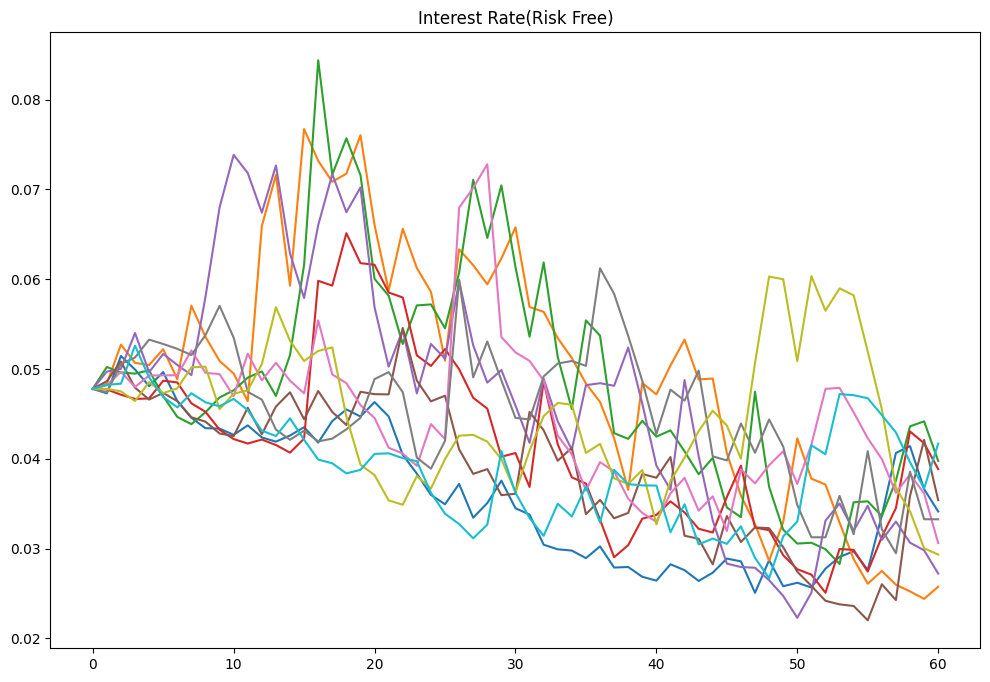

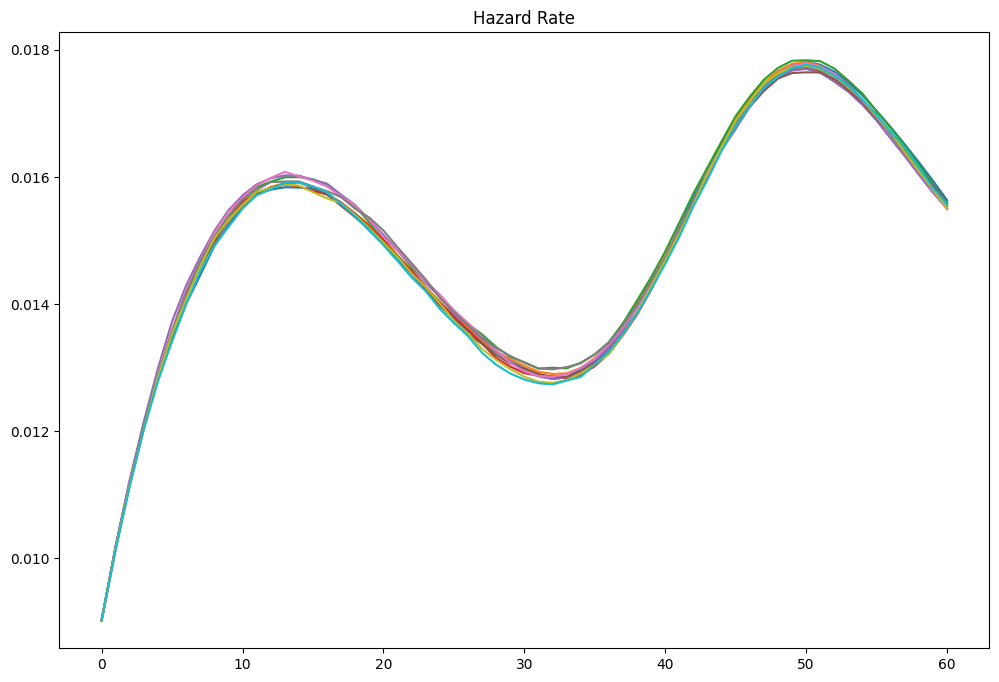

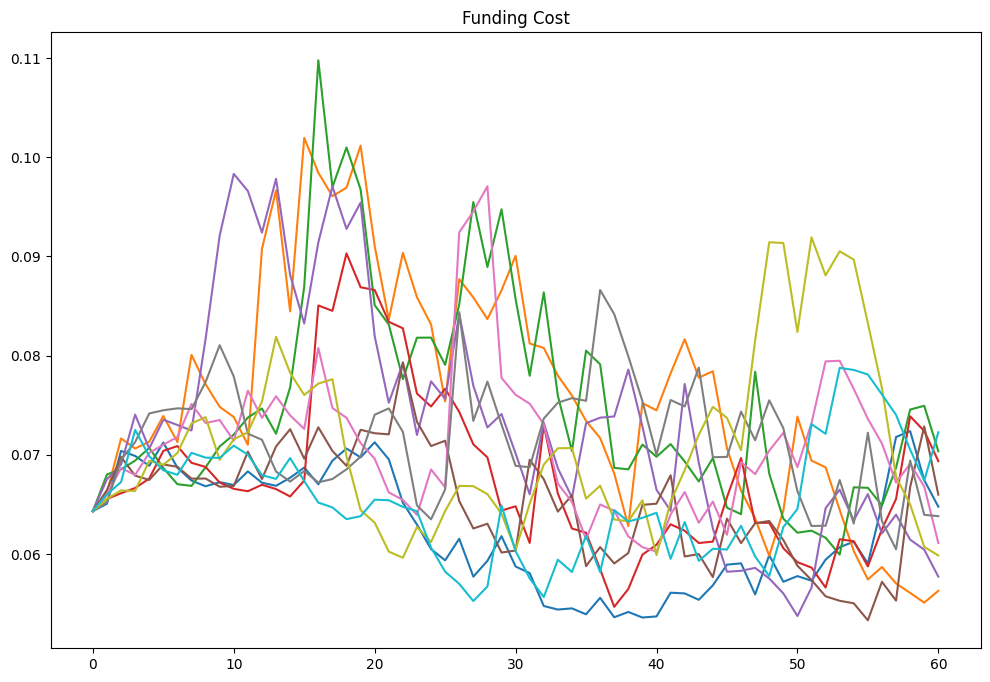

In [3]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
liquidity_risk_bps = np.linspace(0.0025, 0.01, 61)
risk_margin_bps = 0.005
max_loan_tenure = 60
top_tranche_clv_to_display = 10
clv_tables = []
clv_sheet_names = []
ssrd_params = {'simulations': 1000, 'time_step': 1 / 12, 'T': 5, 'rho': 0.3}
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
plot_funding_cost(funding_cost, risk_free_rate, credit_premia)

### Find CLV under normal condition

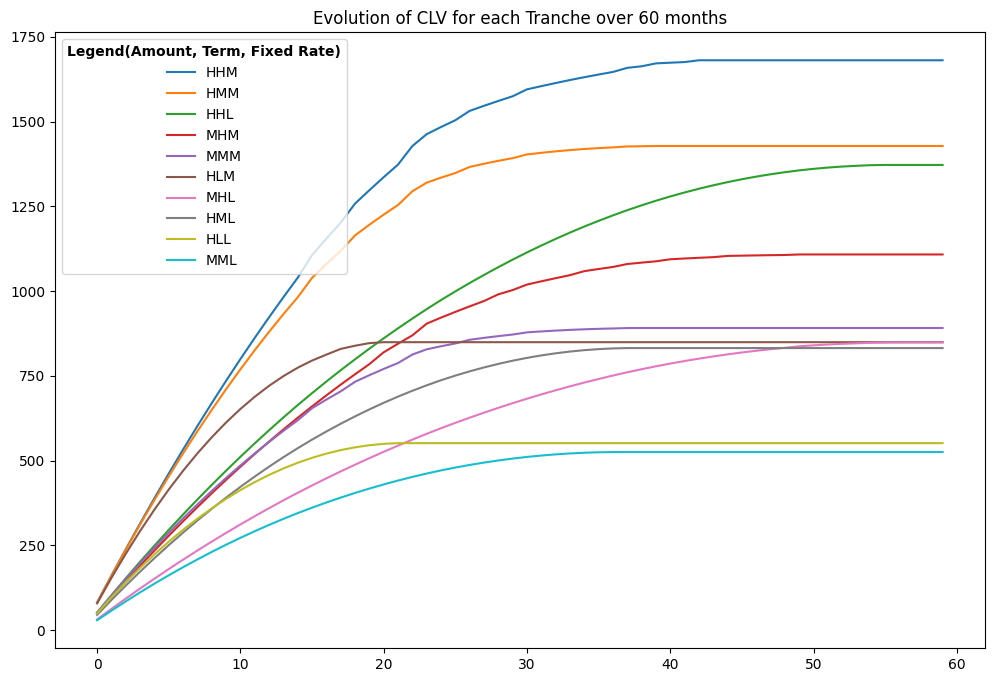

label         clv
  HHM 1681.001199
  HMM 1428.223016
  HHL 1372.276554
  MHM 1108.267743
  MMM  891.348050
  HLM  849.518763
  MHL  848.832093
  HML  832.150179
  HLL  551.750641
  MML  525.483586
  MLM  488.189889
  LHM  441.684045
  HHH  358.863044
  HMH  353.941049
  HLH  351.942370
  LMM  349.445637
  MLL  314.205575
  LHL  270.737972
  MHH  236.897156
  LLM  234.285898
  LML  227.071734
  MLH  222.376575
  MMH  221.107755
  LLL  143.570451
  LHH   91.586799
  LMH   91.229372
  LLH   86.687953


In [4]:
loan_tranches = simulate_loan_tranches()
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('no_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'without_stress');
display_clv(clv_for_excel)

### Under Interest rate 1.1 Vol Stress

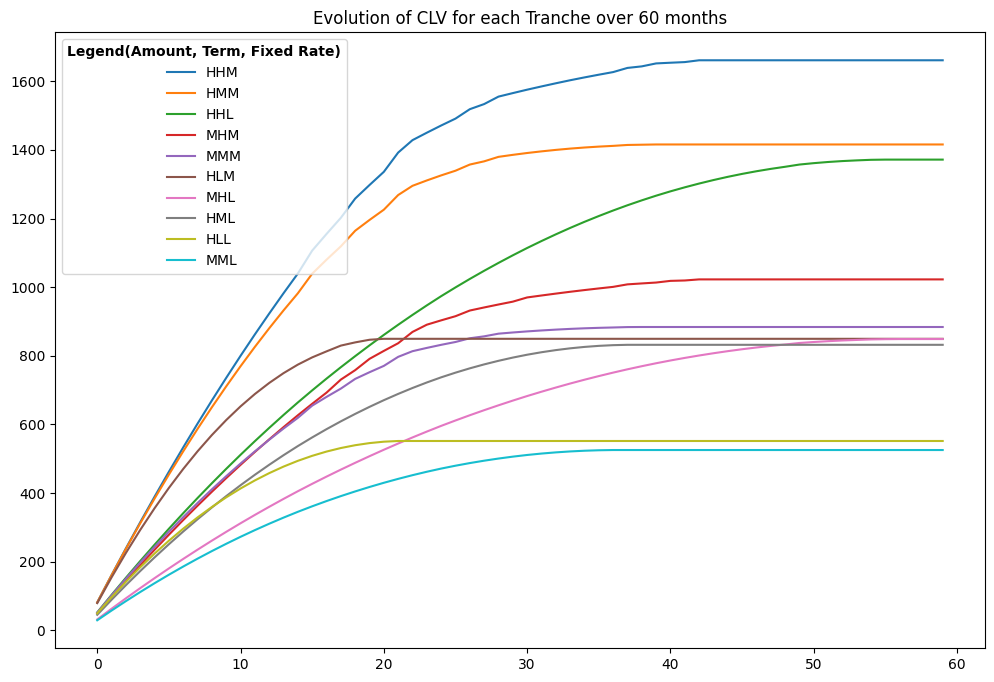

label         clv
  HHM 1661.137973
  HMM 1415.804239
  HHL 1371.687193
  MHM 1022.621999
  MMM  883.900565
  HLM  849.498201
  MHL  848.775513
  HML  832.003543
  HLL  551.729822
  MML  525.392632
  MLM  488.187759
  LHM  422.160054
  HHH  358.864933
  HMH  353.942912
  HLH  351.944222
  LMM  346.220521
  MLL  314.201912
  LHL  270.716822
  MHH  236.898402
  LLM  234.287817
  LML  227.032384
  MLH  222.377746
  MMH  221.108919
  LLL  143.566798
  LHH   91.587281
  LMH   91.229852
  LLH   86.688410


In [5]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_interest_inc_vol_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_interest_increase_vol_stress');
display_clv(clv_for_excel)

### Under 0.9 interest rate vol stress

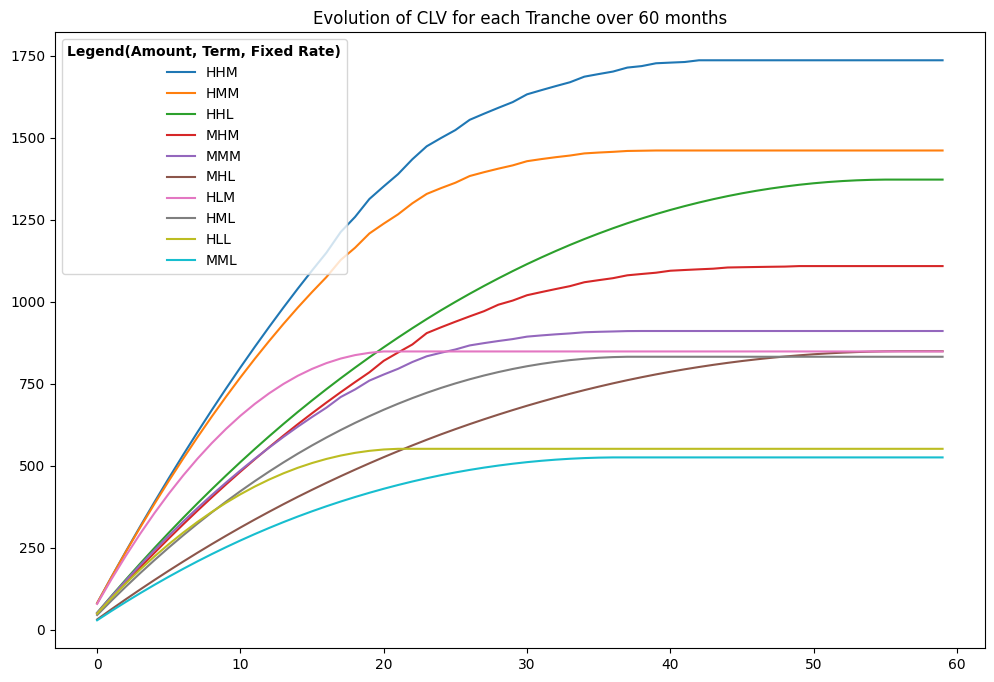

label         clv
  HHM 1735.714144
  HMM 1460.801865
  HHL 1372.129626
  MHM 1108.582225
  MMM  910.737560
  MHL  849.250492
  HLM  848.453796
  HML  832.283634
  HLL  551.768777
  MML  525.566441
  MLM  487.513454
  LHM  457.514577
  LMM  359.988409
  HHH  358.861418
  HMH  353.939445
  HLH  351.940775
  MLL  314.208066
  LHL  270.755989
  MHH  236.896082
  LLM  234.990308
  LML  227.107582
  MLH  222.375568
  MMH  221.106753
  LLL  143.573481
  LHH   91.586384
  LMH   91.228958
  LLH   86.687561


In [6]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_interest_dec_vol_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_interest_decrease_vol_stress');
display_clv(clv_for_excel)

### Under credit risk 1.1 vol stress

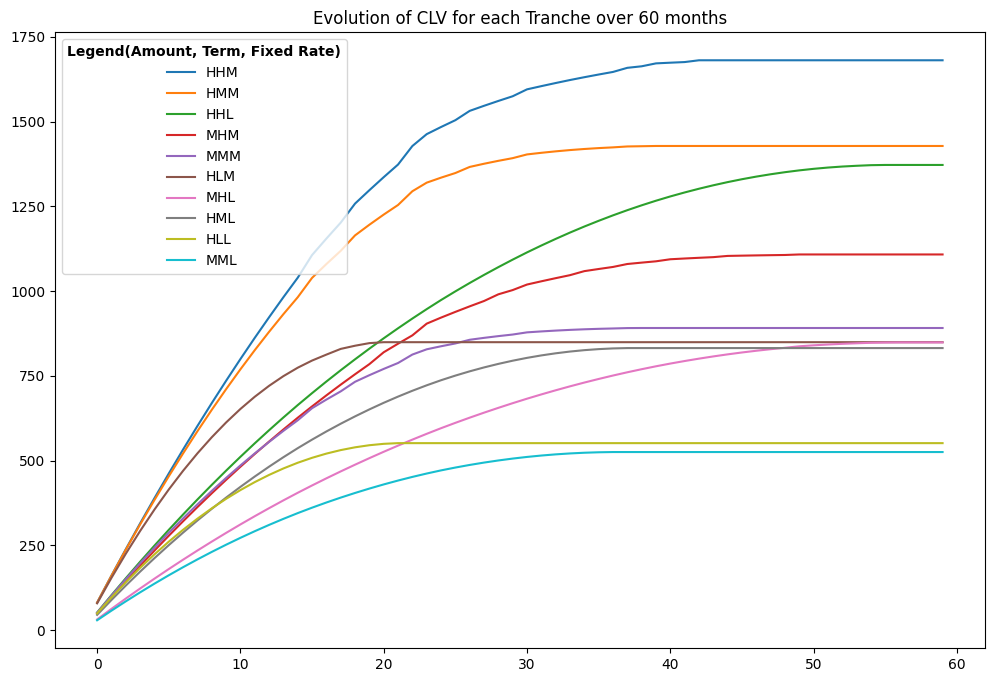

label         clv
  HHM 1680.999222
  HMM 1428.222306
  HHL 1372.277598
  MHM 1108.266273
  MMM  891.347656
  HLM  849.519375
  MHL  848.832740
  HML  832.150407
  HLL  551.751017
  MML  525.483728
  MLM  488.190266
  LHM  441.683529
  HHH  358.863047
  HMH  353.941051
  HLH  351.942372
  LMM  349.445502
  MLL  314.205814
  LHL  270.738177
  MHH  236.897157
  LLM  234.286070
  LML  227.071796
  MLH  222.376577
  MMH  221.107757
  LLL  143.570554
  LHH   91.586799
  LMH   91.229372
  LLH   86.687954


In [7]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_credit_inc_vol_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_credit_increase_vol_stress');
display_clv(clv_for_excel)

### Under credit risk 0.9 vol stress

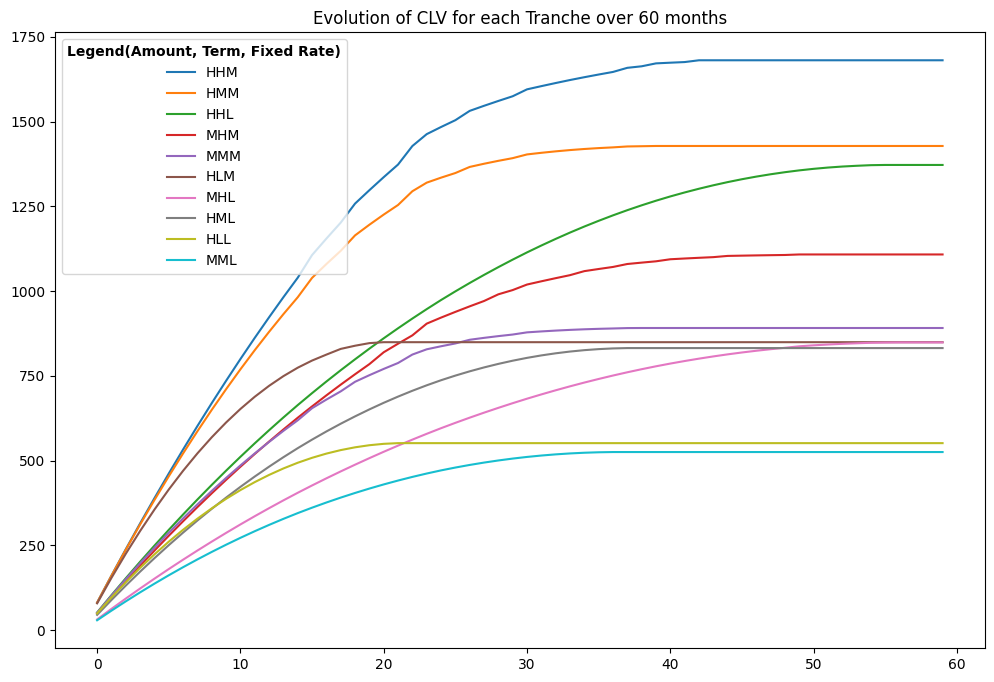

label         clv
  HHM 1681.003177
  HMM 1428.223726
  HHL 1372.275499
  MHM 1108.269211
  MMM  891.348444
  HLM  849.518148
  MHL  848.831439
  HML  832.149948
  HLL  551.750264
  MML  525.483442
  MLM  488.189511
  LHM  441.684560
  HHH  358.863042
  HMH  353.941047
  HLH  351.942368
  LMM  349.445772
  MLL  314.205334
  LHL  270.737765
  MHH  236.897154
  LLM  234.285725
  LML  227.071672
  MLH  222.376574
  MMH  221.107754
  LLL  143.570347
  LHH   91.586798
  LMH   91.229371
  LLH   86.687953


In [8]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_credit_dec_vol_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_credit_increase_dec_stress');
display_clv(clv_for_excel)

### Under interest rate parallel shift stress +10 bps

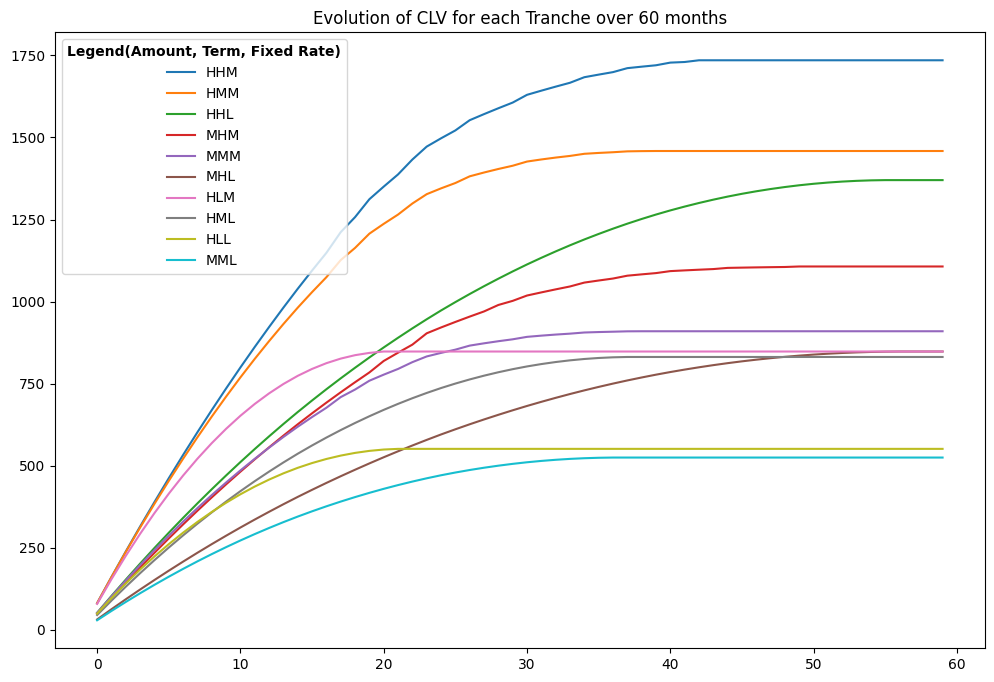

label         clv
  HHM 1735.079111
  HMM 1458.712131
  HHL 1370.048400
  MHM 1106.965908
  MMM  909.676076
  MHL  847.948036
  HLM  847.938236
  HML  831.313508
  HLL  551.414448
  MML  524.968203
  MLM  486.788576
  LHM  448.414296
  LMM  359.555686
  HHH  358.835032
  HMH  353.913421
  HLH  351.914898
  MLL  314.029733
  LHL  270.345522
  MHH  236.878664
  LLM  235.070936
  LML  226.848895
  MLH  222.359217
  MMH  221.090496
  LLL  143.486540
  LHH   91.579650
  LMH   91.222251
  LLH   86.681187


In [9]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_inc_10bps_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_inc_10bps_stress');
display_clv(clv_for_excel)

### Under interest rate parallel shift stress -10 bps

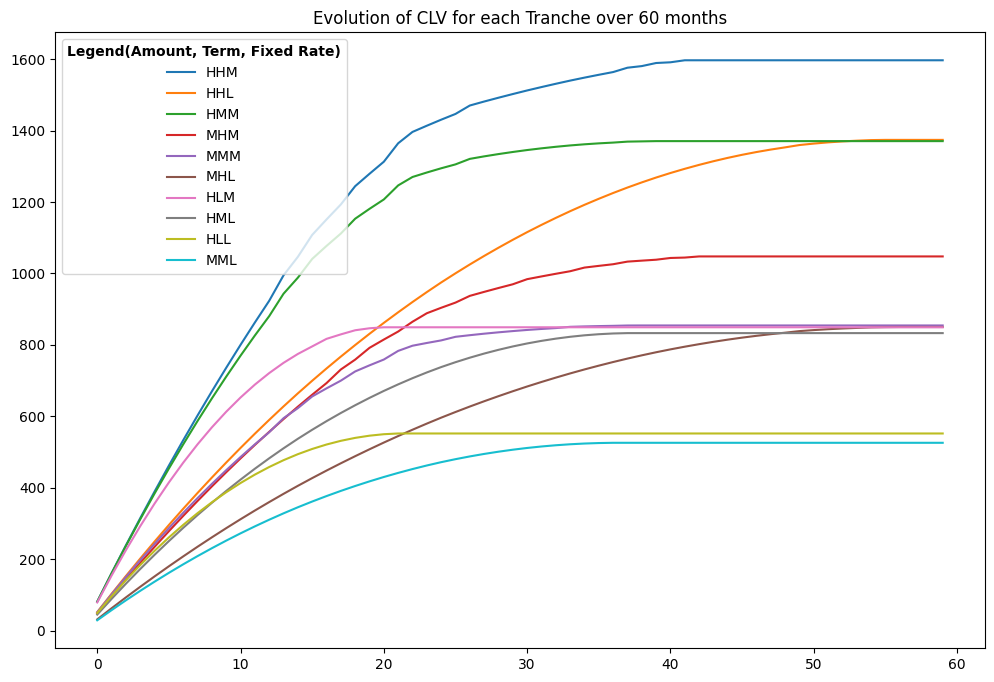

label         clv
  HHM 1596.577912
  HHL 1373.785729
  HMM 1370.317629
  MHM 1047.595573
  MMM  854.414487
  MHL  850.087047
  HLM  849.311865
  HML  832.988885
  HLL  552.087444
  MML  526.000202
  MLM  488.021645
  LHM  417.985094
  HHH  358.891085
  HMH  353.968705
  HLH  351.969870
  LMM  345.905735
  MLL  314.381722
  LHL  271.131648
  MHH  236.915666
  LLM  231.167642
  LML  227.295107
  MLH  222.393951
  MMH  221.125032
  LLL  143.654511
  LHH   91.593955
  LMH   91.236500
  LLH   86.694727


In [10]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] -= 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_dec_10bps_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_dec_10bps_stress');
display_clv(clv_for_excel)

### Under credit spread parallel shift stress +10 bps

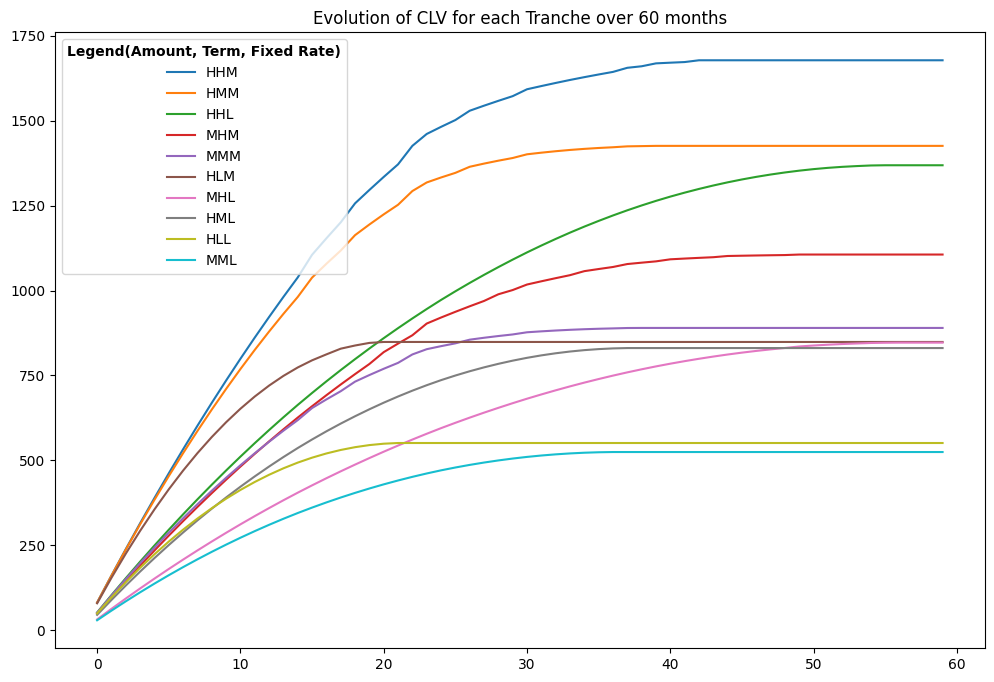

label         clv
  HHM 1678.035584
  HMM 1426.030736
  HHL 1368.961456
  MHM 1106.099930
  MMM  889.999686
  HLM  848.687492
  MHL  846.749268
  HML  830.756842
  HLL  551.190654
  MML  524.625291
  MLM  487.732136
  LHM  440.914864
  HHH  358.816373
  HMH  353.895018
  HLH  351.896599
  LMM  348.916042
  MLL  313.912673
  LHL  270.084564
  MHH  236.866347
  LLM  234.068048
  LML  226.700628
  MLH  222.347655
  MMH  221.079000
  LLL  143.430681
  LHH   91.574888
  LMH   91.217507
  LLH   86.676680


In [11]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_termS['spread'] += 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_cre_term_inc_10bps_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_cre_term_inc_10bps_stress');
display_clv(clv_for_excel)

### Under credit spread parallel shift stress -10 bps

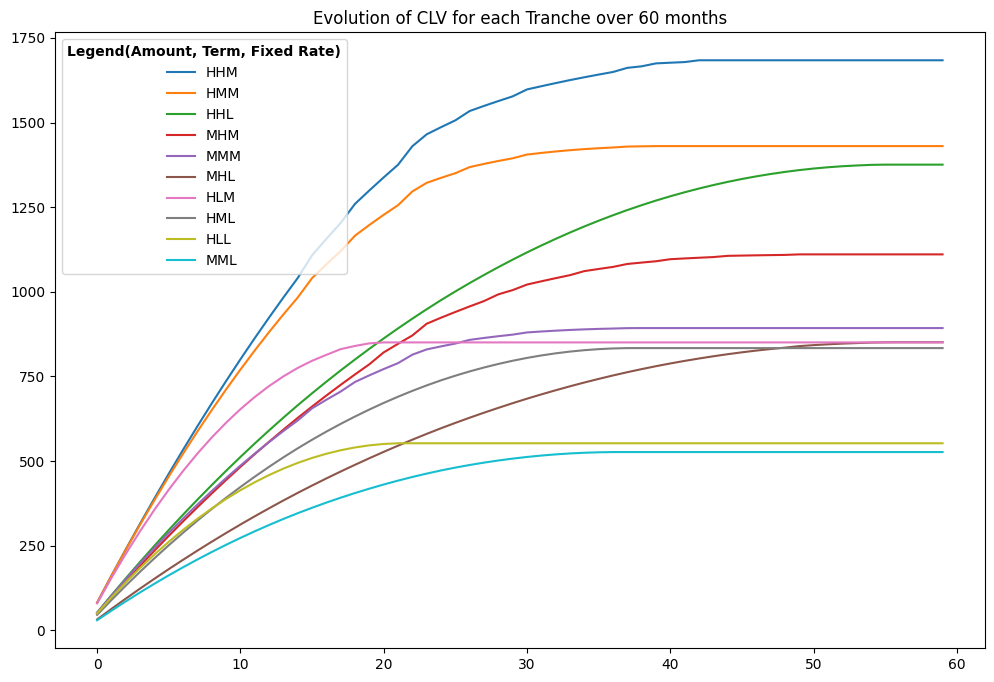

label         clv
  HHM 1683.979179
  HMM 1430.423653
  HHL 1375.608935
  MHM 1110.445218
  MMM  892.701503
  MHL  850.925895
  HLM  850.352500
  HML  833.549157
  HLL  552.312321
  MML  526.345300
  MLM  488.648973
  LHM  442.456407
  HHH  358.909795
  HMH  353.987159
  HLH  351.988219
  LMM  349.977232
  MLL  314.499324
  LHL  271.394785
  MHH  236.928018
  LLM  234.504377
  LML  227.444319
  MLH  222.405546
  MMH  221.136560
  LLL  143.710634
  LHH   91.598730
  LMH   91.241257
  LLH   86.699247


In [12]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
cr_termS['spread'] -= 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_cre_term_dec_10bps_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_cre_term_dec_10bps_stress');
display_clv(clv_for_excel)

### Under Normal yield curve(downward curve)

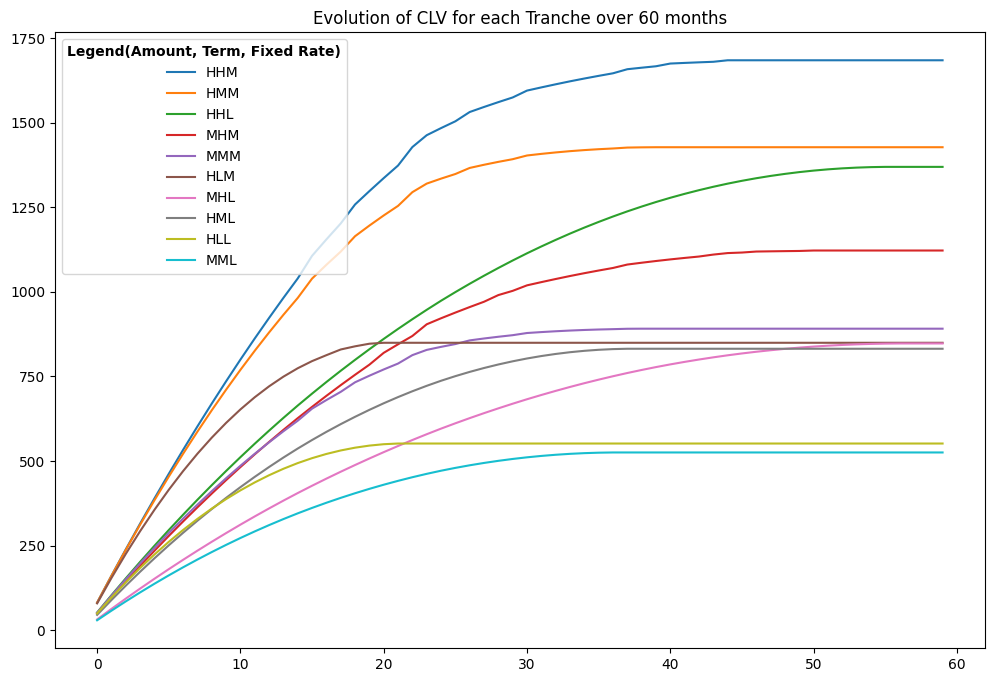

label         clv
  HHM 1684.550258
  HMM 1427.555516
  HHL 1369.461503
  MHM 1122.239534
  MMM  891.172279
  HLM  849.516951
  MHL  847.501295
  HML  831.856494
  HLL  551.748226
  MML  525.322405
  MLM  488.189397
  LHM  445.339988
  HHH  358.862961
  HMH  353.940967
  HLH  351.942289
  LMM  349.376949
  MLL  314.205268
  LHL  270.230224
  MHH  236.897101
  LLM  234.285701
  LML  227.001967
  MLH  222.376524
  MMH  221.107704
  LLL  143.570132
  LHH   91.586777
  LMH   91.229351
  LLH   86.687933


In [13]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
max_index = np.argmax(ir_termS['rate'])
ir_termS.loc[max_index:, 'rate'] = ir_termS['rate'][max_index]
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_interest_normalised')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_interest_normalised');
display_clv(clv_for_excel)

### Under less stress on initial curve and more on the end

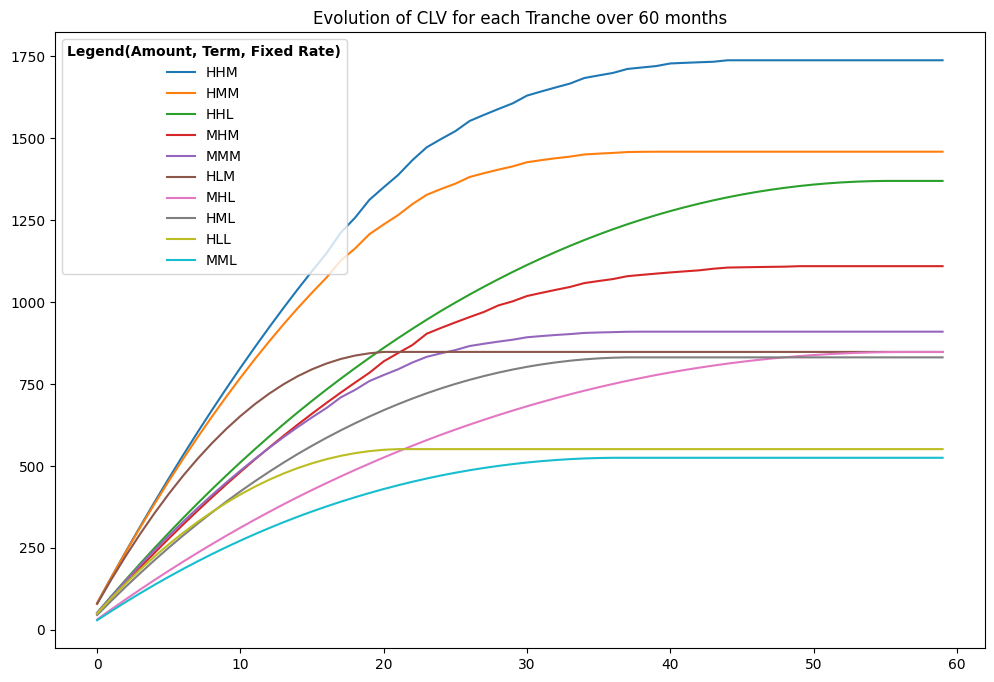

label         clv
  HHM 1737.607077
  HMM 1458.708950
  HHL 1369.580976
  MHM 1109.524905
  MMM  909.675409
  HLM  847.938127
  MHL  847.635234
  HML  831.313672
  HLL  551.414370
  MML  524.968298
  MLM  486.788521
  LHM  449.033776
  LMM  359.555308
  HHH  358.834981
  HMH  353.913371
  HLH  351.914848
  MLL  314.029698
  LHL  270.253449
  MHH  236.878630
  LLM  235.070909
  LML  226.848936
  MLH  222.359186
  MMH  221.090464
  LLL  143.486521
  LHH   91.579636
  LMH   91.222238
  LLH   86.681174


In [14]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ir_termS.loc[len(ir_termS)/2:, 'rate'] += 0.001
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_back_more_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_backend_more_stress');
display_clv(clv_for_excel)

### Under combined stress in vol and yield curve interest rate(increase)

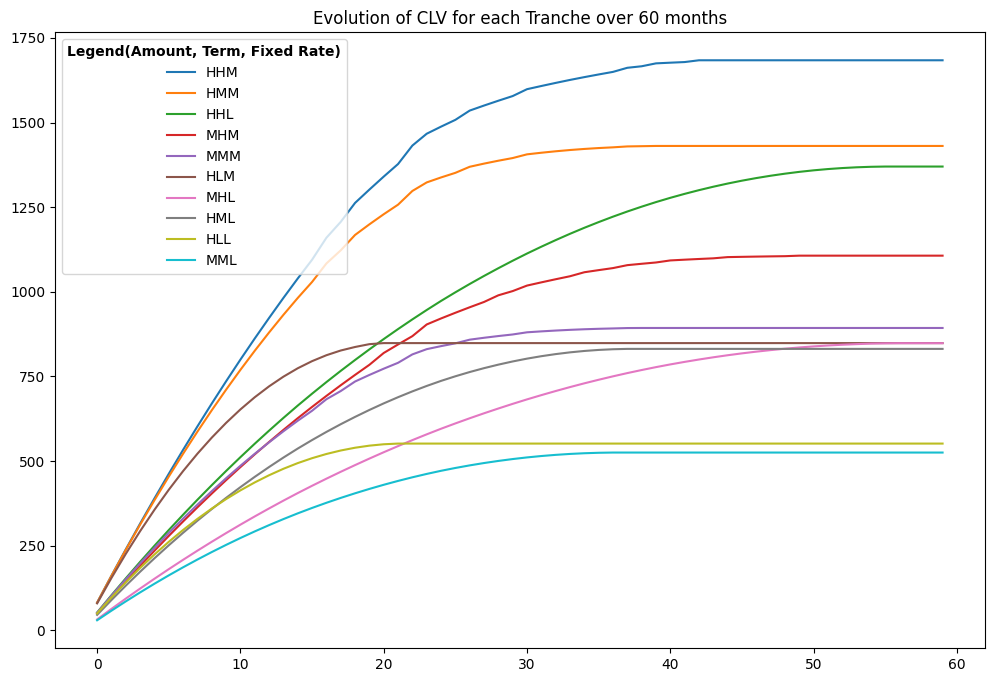

label         clv
  HHM 1683.941154
  HMM 1430.803558
  HHL 1369.941384
  MHM 1106.647475
  MMM  892.961855
  HLM  848.270466
  MHL  848.032883
  HML  831.167268
  HLL  551.393694
  MML  524.877496
  MLM  487.910256
  LHM  442.776911
  HHH  358.836919
  HMH  353.915282
  HLH  351.916749
  LMM  350.027897
  MLL  314.026090
  LHL  270.324373
  MHH  236.879910
  LLM  234.853722
  LML  226.809651
  MLH  222.360387
  MMH  221.091659
  LLL  143.482900
  LHH   91.580131
  LMH   91.222730
  LLH   86.681643


In [15]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ir_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_vol_inc_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_vol_increase_stress');
display_clv(clv_for_excel)

### Under combined stress in vol and yield curve interest rate(decrease)

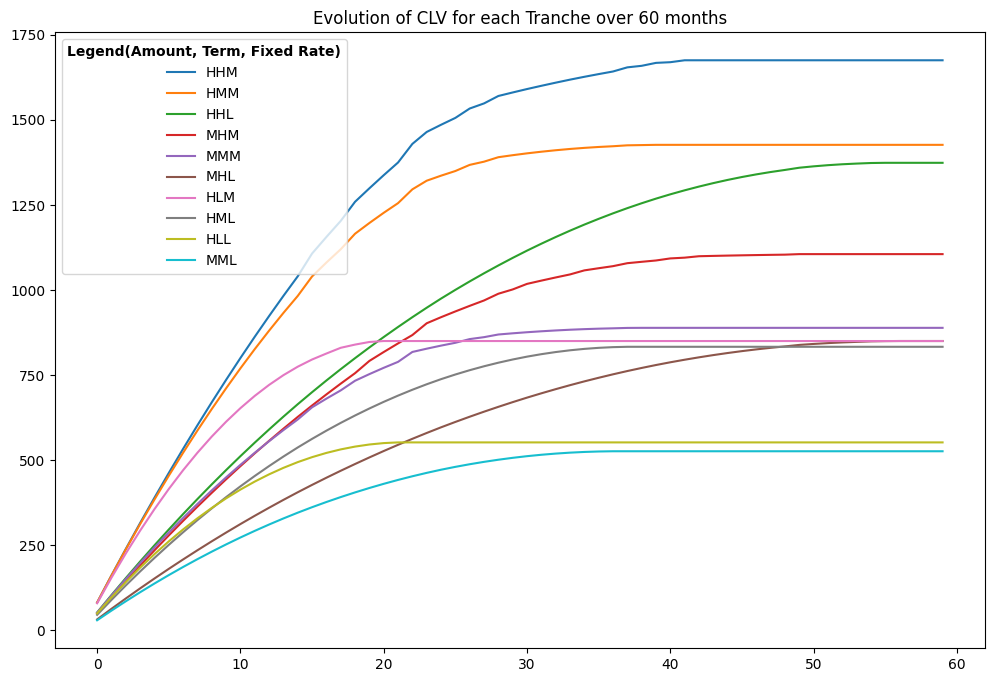

label         clv
  HHM 1675.246254
  HMM 1426.697486
  HHL 1373.873497
  MHM 1105.490474
  MMM  888.818231
  MHL  850.134484
  HLM  850.035209
  HML  833.122705
  HLL  552.105640
  MML  526.083284
  MLM  488.468011
  LHM  441.900037
  HHH  358.889457
  HMH  353.967099
  HLH  351.968273
  LMM  349.836958
  MLL  314.384230
  LHL  271.149661
  MHH  236.914592
  LLM  234.414383
  LML  227.331052
  MLH  222.392943
  MMH  221.124029
  LLL  143.657553
  LHH   91.593540
  LMH   91.236086
  LLH   86.694334


In [16]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] -= 0.001
ir_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_vol_dec_stress')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_vol_increase_stress');
display_clv(clv_for_excel)

### Under combined stress in vol(increase) and yield curve(decrease) interest rate

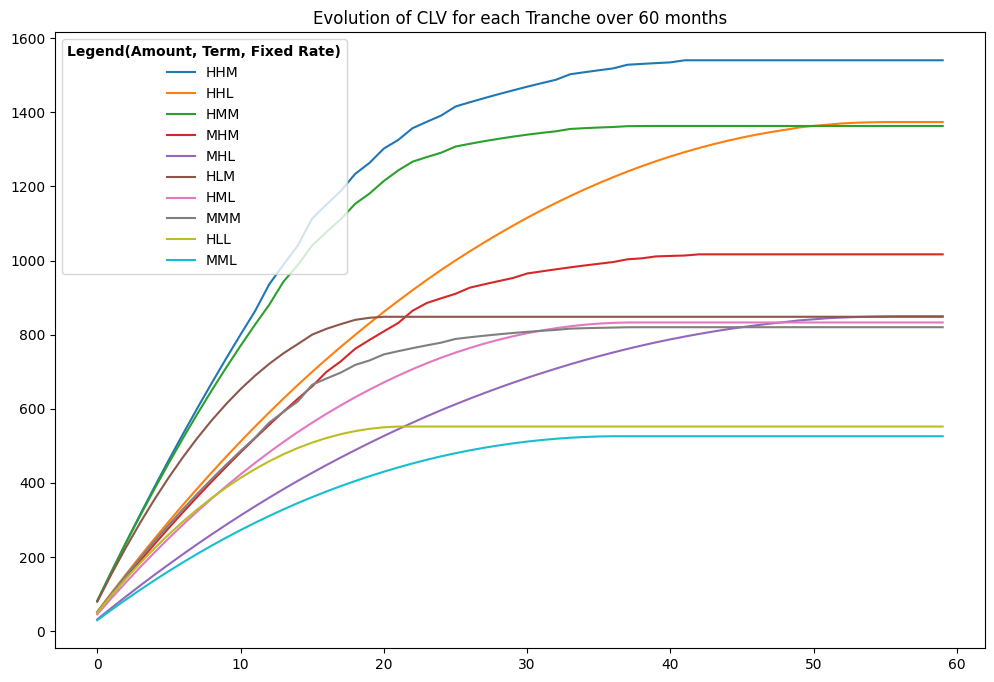

label         clv
  HHM 1540.332124
  HHL 1373.602731
  HMM 1363.041685
  MHM 1016.680001
  MHL  849.746010
  HLM  848.225460
  HML  832.841850
  MMM  820.098990
  HLL  552.066561
  MML  525.909000
  MLM  488.015894
  LHM  398.908271
  HHH  358.892975
  HMH  353.970570
  HLH  351.971724
  LMM  333.154350
  MLL  314.378040
  LHL  271.157720
  MHH  236.916914
  LLM  227.583014
  LML  227.255649
  MLH  222.395123
  MMH  221.126197
  LLL  143.650845
  LHH   91.594437
  LMH   91.236981
  LLH   86.695184


In [17]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] -= 0.001
ir_params['sigma'] *= 1.1
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_dec_vol_inc')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_dec_vol_inc');
display_clv(clv_for_excel)

### Under combined stress in vol(decrease) and yield curve(increase) interest rate

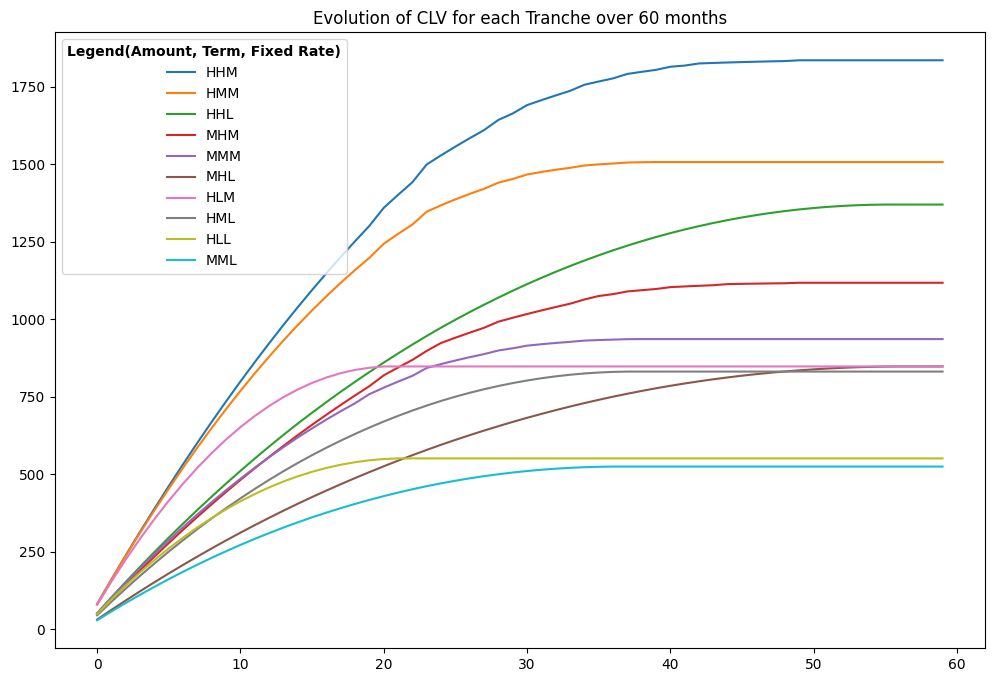

label         clv
  HHM 1835.491390
  HMM 1507.247982
  HHL 1370.139570
  MHM 1117.899212
  MMM  936.253154
  MHL  847.997848
  HLM  847.955893
  HML  831.446598
  HLL  551.432525
  MML  525.050831
  MLM  486.792645
  LHM  481.500485
  LMM  366.800670
  HHH  358.833408
  HMH  353.911819
  HLH  351.913305
  MLL  314.032208
  LHL  270.363543
  MHH  236.877592
  LLM  235.070936
  LML  226.884644
  MLH  222.358211
  MMH  221.089495
  LLL  143.489558
  LHH   91.579235
  LMH   91.221838
  LLH   86.680794


In [18]:
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
ir_termS['rate'] += 0.001
ir_params['sigma'] *= 0.9
ssrd = generate_ssrd_model(ir_termS, cr_termS, ir_params, cr_params, ssrd_params)
funding_cost, risk_free_rate, credit_premia = simulate_funding_cost(ssrd, liquidity_risk_bps, risk_margin_bps)
clv_labels, trancheClvs, clv_for_excel = find_clv(loan_tranches, funding_cost, risk_free_rate, max_loan_tenure)
clv_tables.append(clv_for_excel)
clv_sheet_names.append('with_int_term_inc_vol_dec')
plot_clv(clv_labels, trancheClvs, max_loan_tenure, top_tranche_clv_to_display, 'with_int_term_inc_vol_dec');
display_clv(clv_for_excel)

In [19]:
write_clv_to_excel(clv_tables, clv_sheet_names)